# Regression for $\pi \pm$ with NO EMProb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import process_time as pt
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

## Declare GPUs - Import Tensorflow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf

## Import EnergyFlow

In [3]:
import energyflow as ef
from energyflow.archs import PFN
print('Energy Flow Version: '+str(ef.__version__))

Energy Flow Version: 1.3.2


## Load Data
Data does not include tracks

X = [Energy, Eta, Phi, rPerp, calo_layer]

Y = [EnergyEM, EnergyNonEM]

Yt = [truthPartE, all_cluster_ENG_CALIB_TOT]

In [4]:
t0 = pt()
Xraw = np.load('/data/atlas/rbate/PIPM_X_15_files.npy', mmap_mode='r')[:,:,:]
Yreg = np.load('/data/atlas/rbate/PIPM_Y_regr_15_files.npy', mmap_mode='r')[:30283,:]
print(Xraw.shape)
print(Yreg.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/XRr_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 4))

# Make sure that non-zero elements are copied as zeros due to mis-match
np.copyto(dst=X[:,:,:], src=Xraw[:,:,:4], casting='same_kind', where=True)
t1 = pt()

print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

(30283, 848, 5)
(30283, 2)
Time to load memory mapped data: 1.0932706799999998 (s)


#### Normalize Target

In [5]:
## REGRESSION TARGET ##
Y = np.ndarray.copy(np.log(Yreg[:,0]))

#### Show Targets

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


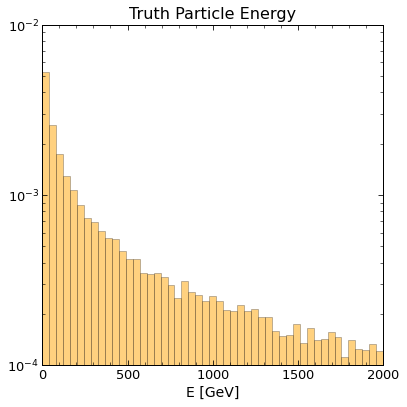

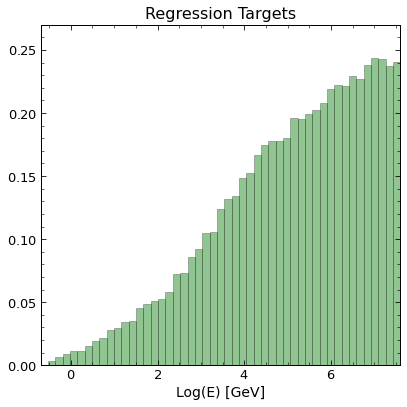

In [6]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yreg[:,0], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='Particle Truth Energy')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.0001,.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/EnergyTargets_PIPMnoEM_log_2021-11-22.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(.5), np.log(2000), 50, endpoint=True)
plt.hist(Y, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Targets', fontsize=16)
plt.xlabel('Log(E) [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.27)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/EnergyTargets_PIPMnoEM_log_2021-11-22.png', format='png')
plt.show()

### Normalize Inputs

In [7]:
t0 = t.time()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[rPerp_mask,3] = X[rPerp_mask,3]/3630.

## Energy Values that are not zero!
Enz_mask = X[:,:,0] != 0
X[Enz_mask,0] = np.log(X[Enz_mask,0])
cellE_mean = np.mean(X[Enz_mask,0])
cellE_std = np.std(X[Enz_mask,0])
X[Enz_mask,0] = (X[Enz_mask,0] - cellE_mean)/cellE_std

## Eta and Phi
# eta_mask = X[:,:,1] != 0
X[rPerp_mask,1] = X[rPerp_mask,1]/.7

# phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[rPerp_mask,2])
X[rPerp_mask,2] = X[rPerp_mask,2]/cellPhi_std
t1 = t.time()

print('Time to Normalize: '+str(t1-t0)+' (s)')

Time to Normalize: 1.8643999099731445 (s)


#### Plot Inputs

<Figure size 799.992x599.976 with 0 Axes>

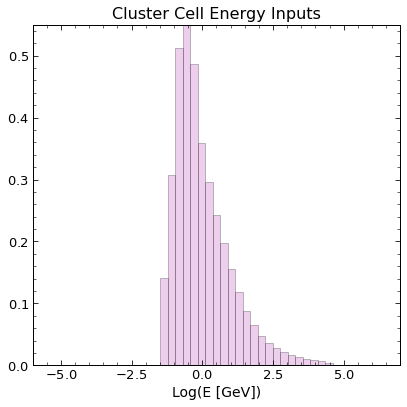

<Figure size 799.992x599.976 with 0 Axes>

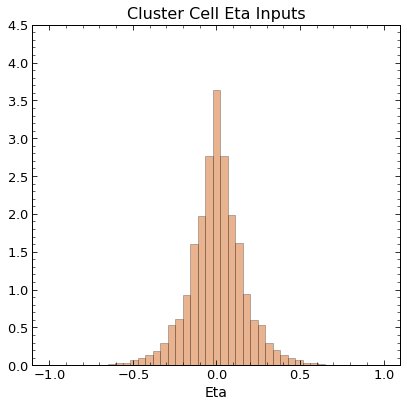

<Figure size 799.992x599.976 with 0 Axes>

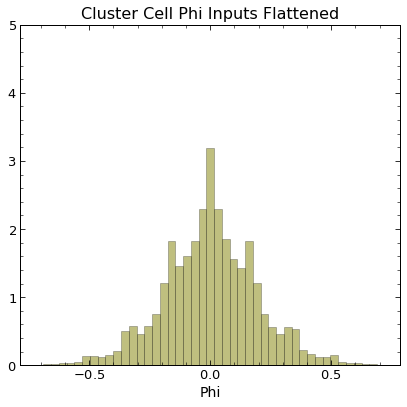

<Figure size 799.992x599.976 with 0 Axes>

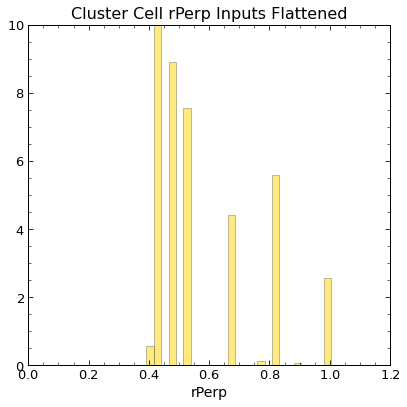

In [8]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[Enz_mask,0], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_E_2021-07-26.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X[rPerp_mask,1], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Eta_2021-07-26.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,50, endpoint=True)
plt.hist(X[rPerp_mask,2], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Phi_2021-07-26.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[rPerp_mask,3], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_rPerp_2021-07-26.png', format='png')
plt.show()

## Model Settings

In [9]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = dsu.tvt_num(X, tvt=(70, 15, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 3000

train -- val -- test
21198 -- 4542 -- 4543


## Data Handling

### Shuffle Data

In [10]:
indices = np.arange(X.shape[0], dtype=int)
np.random.shuffle(indices)
X = X[indices,:,:]
Y = Y[indices]

### Train/Val/Test Split

In [11]:
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X, Y, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(21198, 848, 4)
(21198,)


### Build Particle Flow Network

In [12]:
netOpt = tf.keras.optimizers.Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

pfn = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt, metrics=[])

2021-11-26 17:30:19.188132: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-11-26 17:30:19.188175: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 0
2021-11-26 17:30:19.188626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

### Train Model

In [13]:
t0 = t.time()
history = pfn.fit(x_train, y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1)
t1 = t.time()

2021-11-26 17:32:00.674621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1500
8/8 [==============================] - 12s 1s/step - loss: 5194.6299 - val_loss: 791.6967
Epoch 2/1500
8/8 [==============================] - 1s 143ms/step - loss: 460.8239 - val_loss: 282.7825
Epoch 3/1500
8/8 [==============================] - 1s 142ms/step - loss: 188.6511 - val_loss: 51.8042
Epoch 4/1500
8/8 [==============================] - 1s 143ms/step - loss: 114.5046 - val_loss: 135.3961
Epoch 5/1500
8/8 [==============================] - 1s 145ms/step - loss: 67.8182 - val_loss: 21.0035
Epoch 6/1500
8/8 [==============================] - 1s 144ms/step - loss: 24.6726 - val_loss: 25.8275
Epoch 7/1500
8/8 [==============================] - 1s 144ms/step - loss: 16.0853 - val_loss: 16.4398
Epoch 8/1500
8/8 [==============================] - 1s 145ms/step - loss: 15.6311 - val_loss: 9.0170
Epoch 9/1500
8/8 [==============================] - 1s 144ms/step - loss: 9.6878 - val_loss: 7.8920
Epoch 10/1500
8/8 [==============================] - 1s 141ms/step - loss: 7.68

In [14]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 1864.0313696861267 (s)
31.06718949476878 (min)
0.5177864915794796 (hour)


### Loss Curves

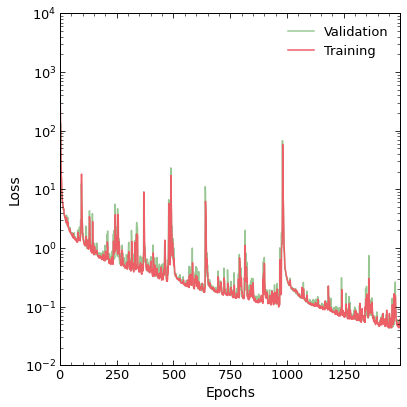

In [20]:
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], label="Validation")
plt.plot(history.history['loss'], label="Training")
plt.yscale('log')
# plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,len(history.history['loss'])-1)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
# plt.text(1000, 1, 'Batch: 3000', fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/pipmNoEM_lossCurves_3000batch_LR1e-3_2021-11-29.png', format='png')
plt.show()

### Predictions

In [16]:
preds = np.exp(pfn.predict(x_test, batch_size=batch_size).flatten())
print(preds.shape)

(4543,)


### Histogram of Predictions

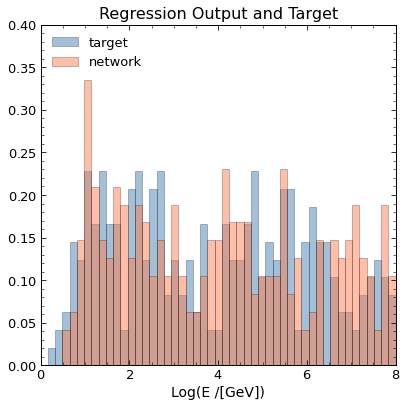

In [21]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(y_test), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/NoEMtargetPreds_3000batch_LR1e-3_2021-11-29.png', format='png')
plt.show()

## Analytics

### Response Plots

<Figure size 799.992x599.976 with 0 Axes>

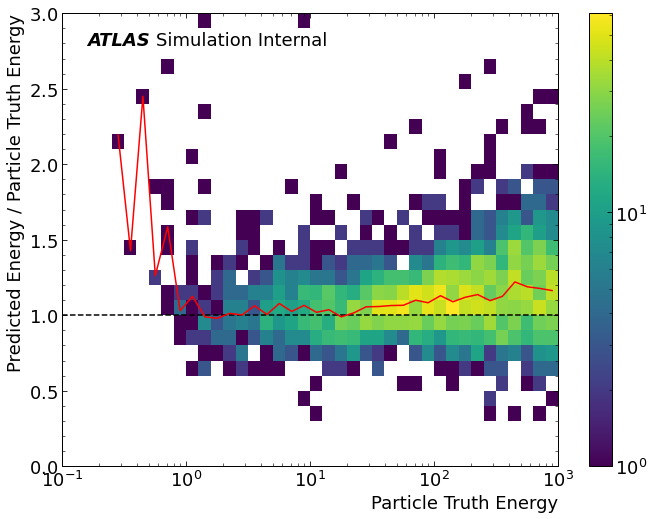

In [22]:
resplot = ru.responsePlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                figfile='',
                statistic='median', xlabel='Particle Truth Energy', ylabel='Predicted Energy / Particle Truth Energy',
                atlas_x=.05, atlas_y=.96, simulation=True, cblabel='',
                textlist=[])

# Regression_Plots/November21/ResponsePlotNoEM_3000batch_LR1e-3_2021-11-29.png

### Resolution Plots

<Figure size 799.992x599.976 with 0 Axes>

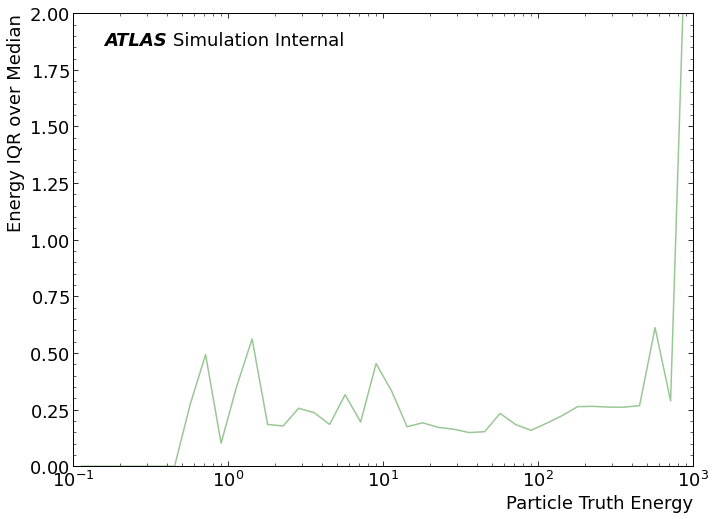

In [24]:
resp_plot = ru.resolutionPlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                    figfile='Regression_Plots/November21/ResolutionPlotNoEM_3000batch_LR1e-3_2021-11-29.png',
                    statistic='std', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=.05, atlas_y=.96, simulation=True,
                    textlist=[])

